In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, make_scorer

import warnings
warnings.filterwarnings("ignore")

import joblib

In [2]:
data = pd.read_csv('/kaggle/input/medicine-recommendation-system-dataset/Training.csv', delimiter=',')
data

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,(vertigo) Paroymsal Positional Vertigo
4916,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,Acne
4917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Urinary tract infection
4918,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,Psoriasis


In [3]:
np.unique(data['prognosis'])

array(['(vertigo) Paroymsal  Positional Vertigo', 'AIDS', 'Acne',
       'Alcoholic hepatitis', 'Allergy', 'Arthritis', 'Bronchial Asthma',
       'Cervical spondylosis', 'Chicken pox', 'Chronic cholestasis',
       'Common Cold', 'Dengue', 'Diabetes ',
       'Dimorphic hemmorhoids(piles)', 'Drug Reaction',
       'Fungal infection', 'GERD', 'Gastroenteritis', 'Heart attack',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E',
       'Hypertension ', 'Hyperthyroidism', 'Hypoglycemia',
       'Hypothyroidism', 'Impetigo', 'Jaundice', 'Malaria', 'Migraine',
       'Osteoarthristis', 'Paralysis (brain hemorrhage)',
       'Peptic ulcer diseae', 'Pneumonia', 'Psoriasis', 'Tuberculosis',
       'Typhoid', 'Urinary tract infection', 'Varicose veins',
       'hepatitis A'], dtype=object)

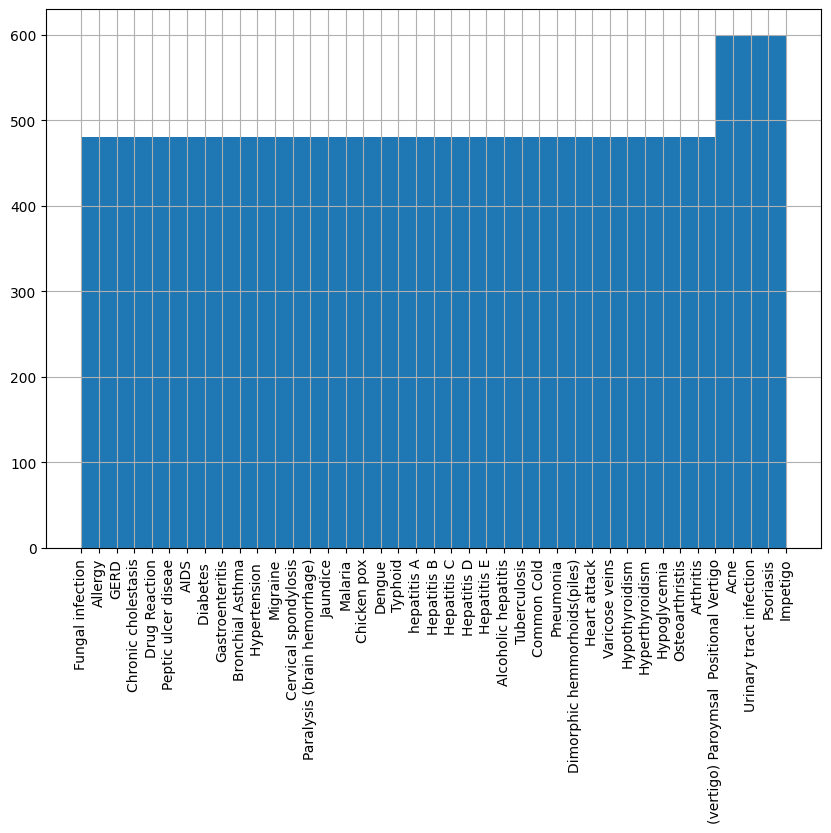

In [4]:
data['prognosis'].hist(figsize=(10, 7))
plt.xticks(rotation = 90)
plt.show()

In [5]:
categorical_cols = list(data.columns[:-1])
target_col = ['prognosis']

print(categorical_cols)

['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing', 'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity', 'ulcers_on_tongue', 'muscle_wasting', 'vomiting', 'burning_micturition', 'spotting_ urination', 'fatigue', 'weight_gain', 'anxiety', 'cold_hands_and_feets', 'mood_swings', 'weight_loss', 'restlessness', 'lethargy', 'patches_in_throat', 'irregular_sugar_level', 'cough', 'high_fever', 'sunken_eyes', 'breathlessness', 'sweating', 'dehydration', 'indigestion', 'headache', 'yellowish_skin', 'dark_urine', 'nausea', 'loss_of_appetite', 'pain_behind_the_eyes', 'back_pain', 'constipation', 'abdominal_pain', 'diarrhoea', 'mild_fever', 'yellow_urine', 'yellowing_of_eyes', 'acute_liver_failure', 'fluid_overload', 'swelling_of_stomach', 'swelled_lymph_nodes', 'malaise', 'blurred_and_distorted_vision', 'phlegm', 'throat_irritation', 'redness_of_eyes', 'sinus_pressure', 'runny_nose', 'congestion', 'chest_pain', 'weakness_in_limbs', 'fast_heart_rate', 'pain_during_bow

In [6]:
X, y = data[categorical_cols], data[target_col]

X.shape, y.shape

((4920, 132), (4920, 1))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((3936, 132), (984, 132), (3936, 1), (984, 1))

In [28]:
param_grid = {
    'iterations': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'random_strength': [1, 5, 10],
    'auto_class_weights': ['Balanced', 'SqrtBalanced'], 
    'bootstrap_type': ['Bayesian', 'Bernoulli'],
    'od_type': ['IncToDec', 'Iter'],
}

In [29]:
mcc_scorer = make_scorer(matthews_corrcoef)

In [30]:
model = CatBoostClassifier(loss_function='MultiClass', cat_features=categorical_cols, task_type='GPU', verbose=0)

search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring=mcc_scorer,
        cv=3,
        n_iter=30,
        random_state=42,
        verbose=1,
        n_jobs=1  
)

In [31]:
search.fit(X, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7e63298d49d0>,
                   n_iter=30, n_jobs=1,
                   param_distributions={'auto_class_weights': ['Balanced',
                                                               'SqrtBalanced'],
                                        'bootstrap_type': ['Bayesian',
                                                           'Bernoulli'],
                                        'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 300, 500, 1000],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.03, 0.1],
                                        'od_type': ['IncToDec', 'Iter'],
                                        'random_strength': [1, 5, 10]},
                   random_state=42, scoring=make_scorer(matthews_corrcoef),
                   verbose=1)

In [32]:
search.best_params_

{'random_strength': 1,
 'od_type': 'Iter',
 'learning_rate': 0.03,
 'l2_leaf_reg': 5,
 'iterations': 1000,
 'depth': 10,
 'border_count': 64,
 'bootstrap_type': 'Bernoulli',
 'auto_class_weights': 'SqrtBalanced'}

In [33]:
model = search.best_estimator_

model.fit(X_train, y_train)

val_pred = model.predict(X_val)

print(f"Accuracy: {(val_pred==y_val).sum()/len(y_val)}")

Accuracy: prognosis    1.0
dtype: float64


In [34]:
model.fit(X, y)

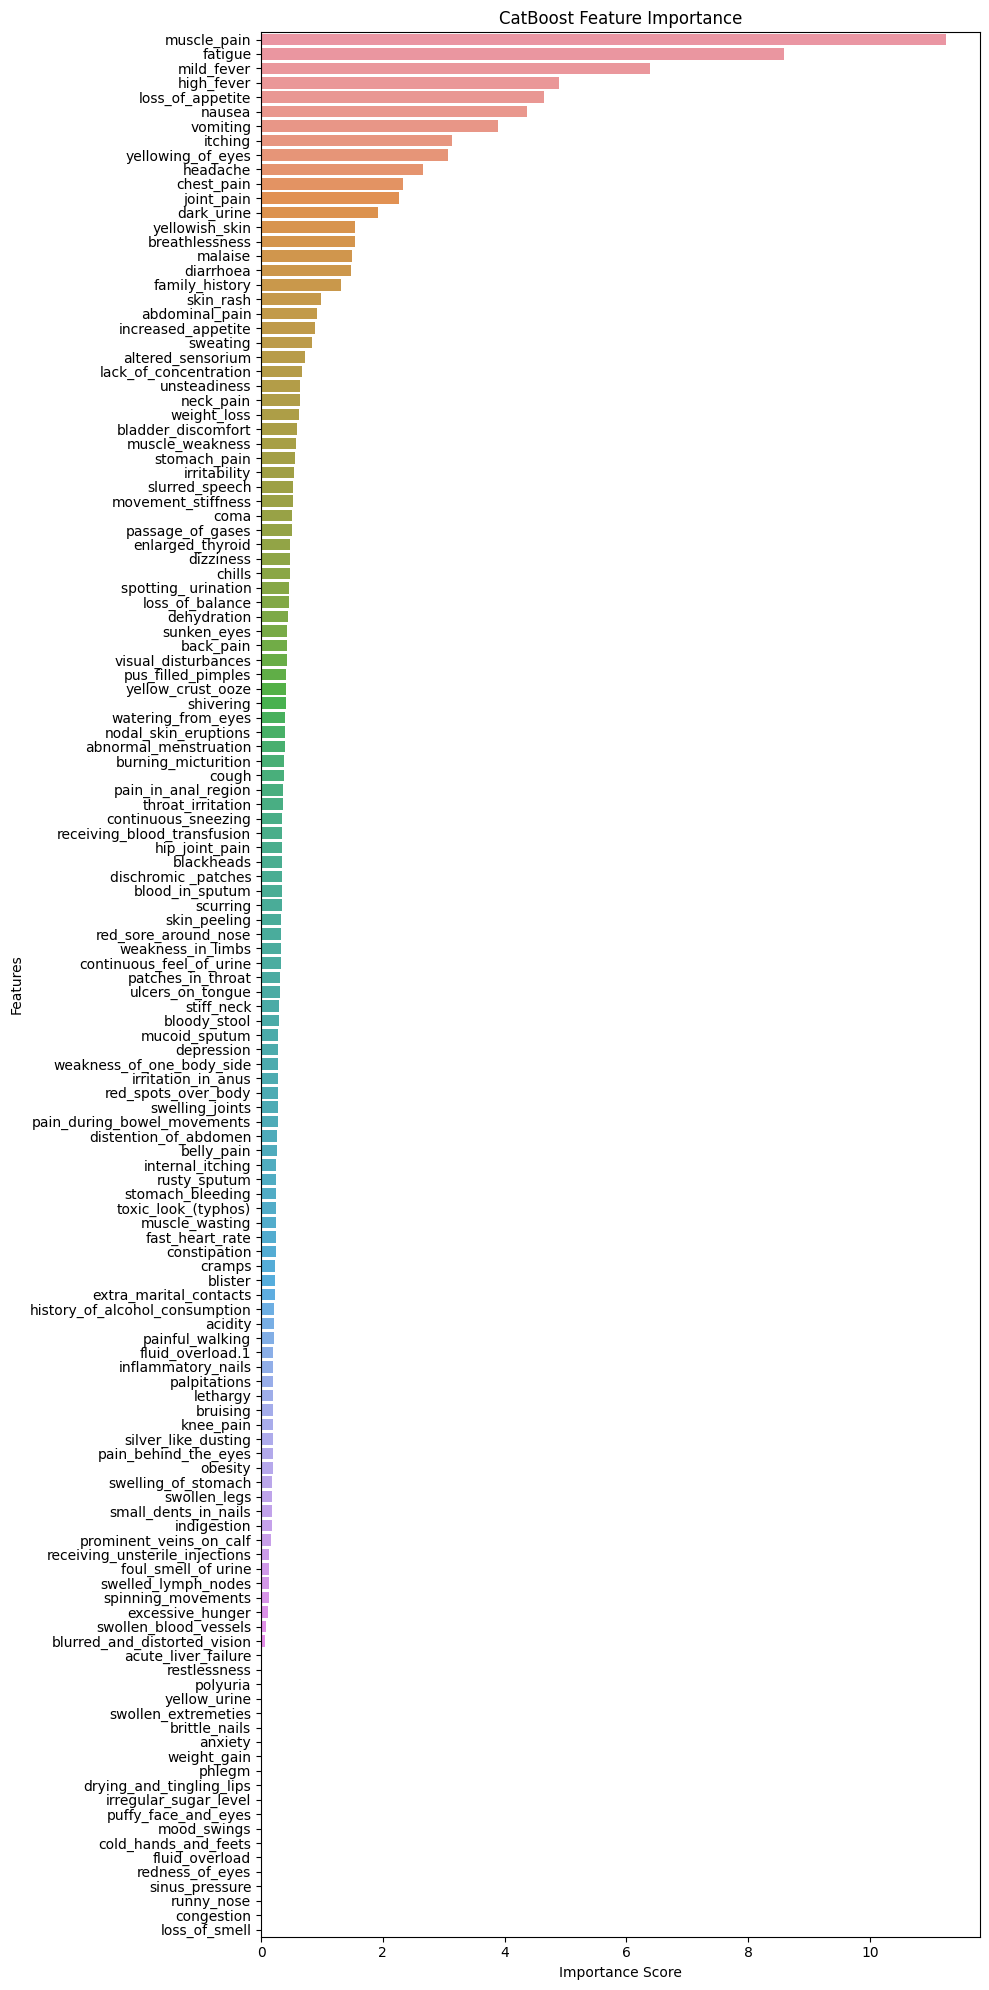

In [69]:
importances = model.get_feature_importance()

feature_importance = list(zip(categorical_cols, importances))
feature_importance.sort(key=lambda x: x[1], reverse=True)
sorted_features, sorted_importances = zip(*feature_importance)

plt.figure(figsize=(10,20))
sns.barplot(x=list(sorted_importances), y=list(sorted_features))
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [72]:
useful_features = list(sorted_features[:11])
useful_features

['muscle_pain',
 'fatigue',
 'mild_fever',
 'high_fever',
 'loss_of_appetite',
 'nausea',
 'vomiting',
 'itching',
 'yellowing_of_eyes',
 'headache',
 'chest_pain']

In [70]:
joblib.dump(model, "Med_Recommender_full.pkl")

['Med_Recommender_full.pkl']